# TODO
* Rapporto tra lavori attivati e cessati in stessi intervalli temporali
* Eventi passati che possono aver influenzato l'attivazione o la cessazione di nuovi lavori
* Correlazione tra lavori attivati e persone pronte per il lavoro(es: appena laureate)
    * Pensare a cosa fare con i dati riguardanti le scuole

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

import utils

STD_SIZE = (15, 10)
MID_SIZE = (25, 20)
BIG_SIZE = (30, 30)

### Study on dataset **Activated Labours**

In [2]:
!ls

activated_labours.ipynb  Rapporti_di_lavoro_attivati.csv
ceased_labours.ipynb	 Rapporti_di_lavoro_cessati.csv
__pycache__		 utils.py


In [3]:
activated_labours = pd.read_csv('Rapporti_di_lavoro_attivati.csv')
activated_labours.head()

,DATA,GENERE,ETA,SETTOREECONOMICODETTAGLIO,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,ITALIANO
0,09/05/2020,F,60,Attività di famiglie e convivenze come datori ...,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO,TEMPO PIENO,BERGAMO,UCRAINA
1,12/07/2019,M,43,"Gestioni di funicolari, ski-lift e seggiovie s...",LICENZA MEDIA,LAVORO A TEMPO DETERMINATO,TEMPO PIENO,BERGAMO,ITALIA
2,05/06/2013,F,20,Fabbricazione di altre apparecchiature elettri...,LICENZA MEDIA,APPRENDISTATO PROFESSIONALIZZANTE O CONTRATTO ...,TEMPO PIENO,BERGAMO,ITALIA
3,12/03/2010,F,28,Alberghi,DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE CH...,LAVORO INTERMITTENTE A TEMPO DETERMINATO,NON DEFINITO,BERGAMO,ITALIA
4,06/04/2021,F,49,Rifugi di montagna,LICENZA MEDIA,LAVORO INTERMITTENTE,NON DEFINITO,BERGAMO,ITALIA


In [4]:
len(activated_labours)

9579794

### Sort records basing on DATA column

Convert values into DATA column into datetime objects 

In [5]:
activated_labours['DATA'] = pd.to_datetime(activated_labours['DATA'])

In [6]:
activated_labours['DATA'].head()

0   2020-09-05
1   2019-12-07
2   2013-05-06
3   2010-12-03
4   2021-06-04
Name: DATA, dtype: datetime64[ns]

Sort basing on dates

In [7]:
activated_labours = activated_labours.sort_values(by='DATA', ascending=True)
activated_labours.reset_index(drop=True, inplace=True)
min_ok = activated_labours.DATA.min() == activated_labours.DATA[0]
max_ok = activated_labours.DATA.max() == activated_labours.DATA[len(activated_labours) - 1]
print('Sorted' if min_ok and max_ok else 'Not sorted')

Sorted


## Inspection of null values

In [8]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 3 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6
SETTOREECONOMICODETTAGLIO,2888,0.0
TITOLOSTUDIO,580,0.0


Only three columns contains null values... Let's inspect more deeply how could i remove them.

### TITOLO DI STUDIO

In [9]:
activated_labours.loc[:, ['TITOLOSTUDIO']].value_counts()

TITOLOSTUDIO                                                                                                           
NESSUN TITOLO DI STUDIO                                                                                                    2721891
LICENZA MEDIA                                                                                                              2523342
DIPLOMA DI ISTRUZIONE SECONDARIA SUPERIORE  CHE PERMETTE L'ACCESSO ALL'UNIVERSITA                                          2430781
LAUREA - Vecchio o nuovo ordinamento                                                                                        988171
TITOLO DI ISTRUZIONE SECONDARIA SUPERIORE (SCOLASTICA ED EXTRA-SCOLASTICA) CHE NON PERMETTE L'ACCESSO ALL'UNIVERSITÀ ()     645228
LICENZA ELEMENTARE                                                                                                           82570
DIPLOMA UNIVERSITARIO                                                                         

I'll fill in all the null values in the **TITOLO DI STUDIO** column with the **NESSUN TITOLO DI STUDIO** value

In [10]:
activated_labours.TITOLOSTUDIO.fillna('NESSUN TITOLO DI STUDIO', inplace=True)

In [11]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 9 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6
SETTOREECONOMICODETTAGLIO,2888,0.0


### SETTORE ECONOMICO DETTAGLIO

In [12]:
counts = activated_labours.loc[:, ['SETTOREECONOMICODETTAGLIO']].value_counts()
counts

SETTOREECONOMICODETTAGLIO                                                                                                                                                      
Alberghi                                                                                                                                                                           467057
Ristorazione con somministrazione                                                                                                                                                  445191
Attività di produzione cinematografica, di video e di programmi televisivi                                                                                                         379116
Attività di famiglie e convivenze come datori di lavoro per personale domestico                                                                                                    348181
Altri servizi di supporto alle imprese nca                                      

<BarContainer object of 18 artists>

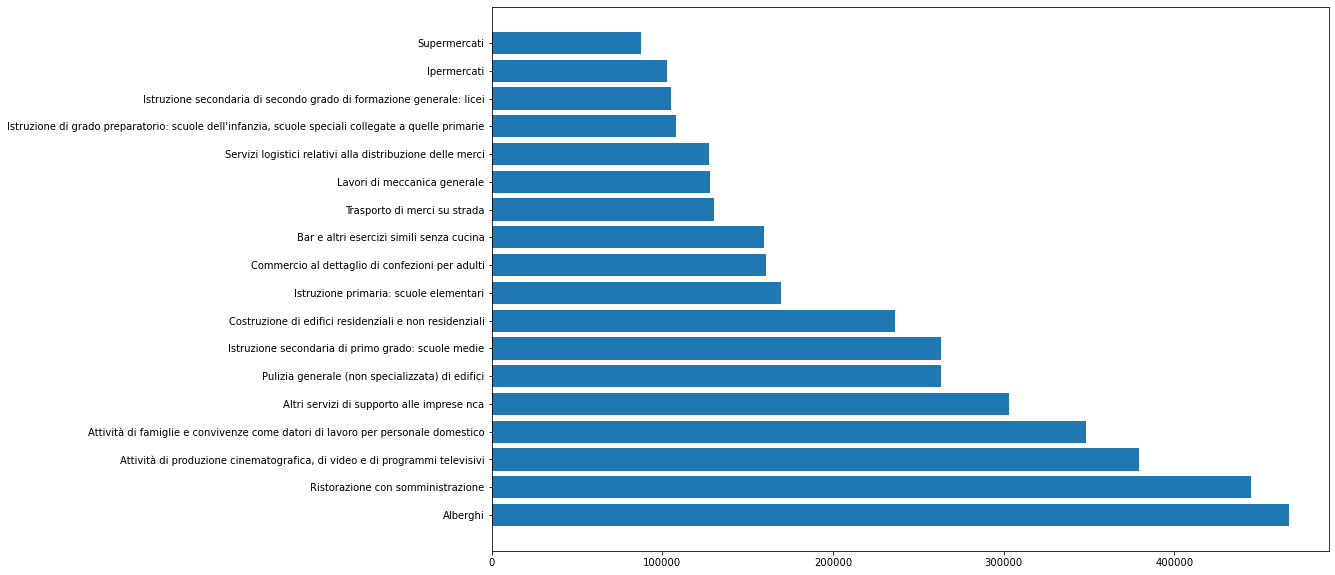

In [13]:
LIMIT = 80000
counts = counts[counts.values > LIMIT]
plt.figure(figsize=STD_SIZE)
plt.barh(y=[i[0] for i in counts.index], width=counts.values)

Column **settore economico dettaglio** contains too general information and not enough useful concerning our study. In order to make an understandable plot i would have to avoid considering too many values, so for now i'll drop it.

In [14]:
activated_labours.drop(labels=['SETTOREECONOMICODETTAGLIO'], axis=1, inplace=True)

In [15]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values
MODALITALAVORO,440779,4.6


### MODALITA LAVORO

In [16]:
activated_labours.loc[:, ['MODALITALAVORO']].value_counts()

MODALITALAVORO            
TEMPO PIENO                   5337940
TEMPO PARZIALE ORIZZONTALE    2026056
NON DEFINITO                  1087460
TEMPO PARZIALE MISTO           445419
TEMPO PARZIALE VERTICALE       242140
dtype: int64

Fill null values into **modalità lavoro** with value **NON DEFINITO**

In [17]:
activated_labours['MODALITALAVORO'] = activated_labours['MODALITALAVORO'].fillna('NON DEFINITO')
activated_labours['MODALITALAVORO'].isnull().sum()

0

In [18]:
utils.missing_values_table(activated_labours)

Your selected dataframe has 8 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


Now the dataframe contains **0** null values.

### Rename column **italiano** into **nazionalita**

In [19]:
activated_labours.rename({'ITALIANO': 'NAZIONALITA'}, axis=1, inplace=True)

# Duplicated records

In [20]:
activated_labours.duplicated().sum()

2536002

the presence of duplicated lines is not meaningful because there could be different people with same characteristics having activated a labour in the same day

## Descriptive statistics

In [21]:
utils.variability_measures(activated_labours, column='ETA')

Mean on column ETA: 35.301741457070996
Median on column ETA: 34.0
Mode on column ETA: 0    25
Name: ETA, dtype: int64
Variance on column ETA: 138.82357821373805
Standard deviation on column ETA: 11.78234179667769
Mean absolute deviation on column ETA: 9.849852522936677
Median absolute deviation on column ETA: 9.768722688608962


# Time series analysis

In this part i will try to find out some patters, autocorrelations and seasonalities

In [22]:
activated_labours.set_index('DATA', inplace=True)
activated_labours.head()

,GENERE,ETA,TITOLOSTUDIO,CONTRATTO,MODALITALAVORO,PROVINCIAIMPRESA,NAZIONALITA
DATA,,,,,,,
1973-02-01,F,20,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1974-11-06,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,MILANO,ITALIA
1976-01-10,F,21,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PARZIALE ORIZZONTALE,BERGAMO,ITALIA
1978-01-05,M,25,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA
1978-10-07,M,26,NESSUN TITOLO DI STUDIO,LAVORO DOMESTICO A TEMPO INDETERMINATO,TEMPO PIENO,MILANO,ITALIA


In [23]:
num_monthly = activated_labours.groupby(activated_labours.index.month).count().iloc[:, [0]]
num_monthly

,GENERE
DATA,
1,758272
2,774982
3,727018
4,716190
5,716028
6,781226
7,805486
8,684845
9,1149358


<AxesSubplot:title={'center':'Monthly total number of activated labours'}, xlabel='Month', ylabel='Number of activated labours'>

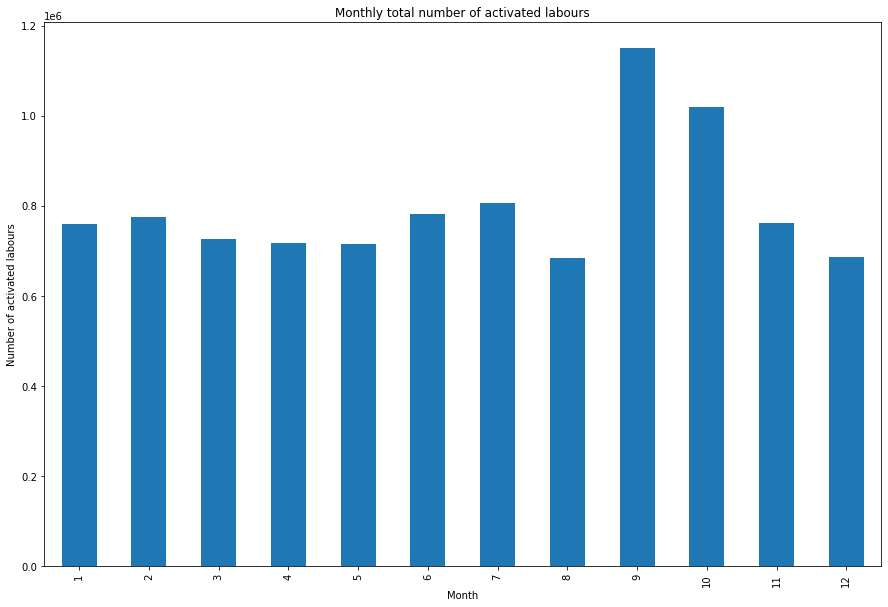

In [24]:
num_monthly.plot(title='Monthly total number of activated labours', 
                 xlabel='Month', 
                 ylabel='Number of activated labours', 
                 kind='bar', 
                 legend=False, 
                 figsize=STD_SIZE)

<AxesSubplot:ylabel='Density'>

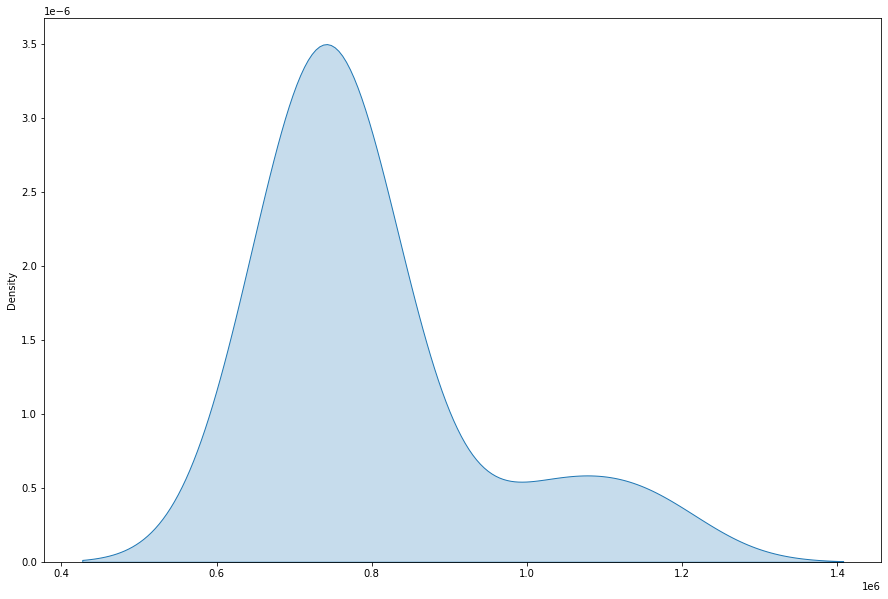

In [25]:
plt.figure(figsize=STD_SIZE)
sns.kdeplot(data=num_monthly.iloc[:, [0]], legend=False, shade=True)

In [26]:
mean_monthly = activated_labours.groupby(activated_labours.index.month).mean().iloc[:, [0]]
mean_monthly

,ETA
DATA,
1,35.982181
2,35.690582
3,35.613849
4,35.379221
5,35.297980
6,34.840576
7,34.565739
8,34.581683
9,36.059236


<AxesSubplot:title={'center':'Monthly mean of activated labours'}, xlabel='Month', ylabel='Number of activated labours'>

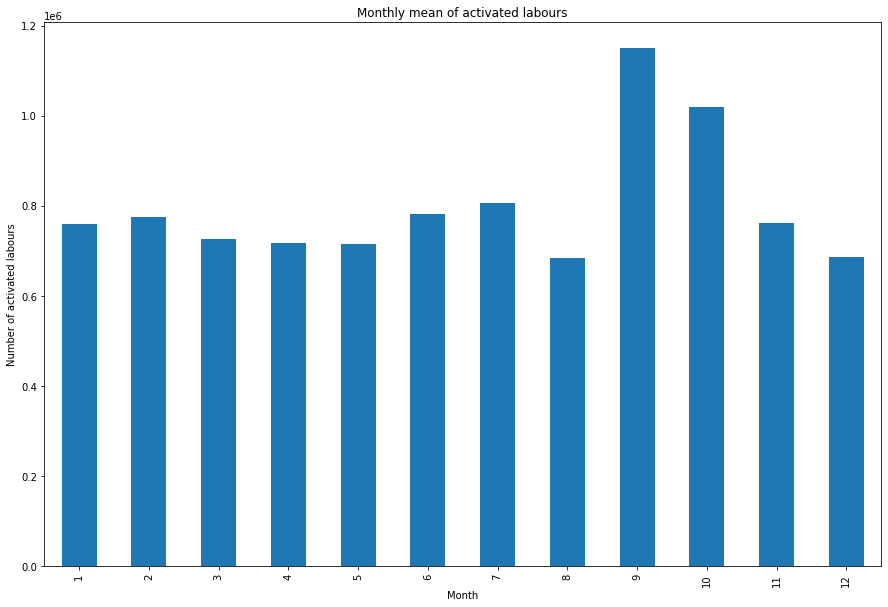

In [27]:
num_monthly.plot(title='Monthly mean of activated labours', 
                 xlabel='Month', 
                 ylabel='Number of activated labours', 
                 kind='bar', 
                 legend=False, 
                 figsize=STD_SIZE)

In [28]:
activated_labours[activated_labours.index.month == 1].groupby('TITOLOSTUDIO')